In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#cv2.imread(fileName, flag[COLOR(1),GRAYSCALE(0),UNCHAGED(-1)]
img1 = cv2.imread('left.jpeg', 0)
img1 = cv2.resize(img1, (800,1000))

img2 = cv2.imread('right.jpeg', 0)
img2 = cv2.resize(img2, (800,1000))

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

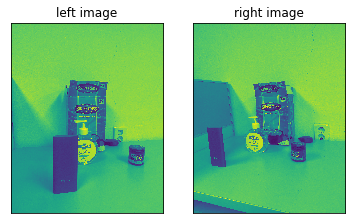

In [3]:
plt.subplot(121), plt.imshow(img1), plt.title('left image')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img2), plt.title('right image')
plt.xticks([]), plt.yticks([])

In [4]:
print(img1.shape)
print(img2.shape)

(1000, 800)
(1000, 800)


In [5]:
#SIFT 객체를 생성
sift = cv2.xfeatures2d.SIFT_create()

# SIFT알고리즘을 사용하여 특징점 및 descriptor생성
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

#SIFT로 추출한 특징점들은 높은 차원의 벡터로 표시되며, 유사도를 찾기 위해 KD-TREE자료형
FLANN_INDEX_KDTREE = 1 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)#SIFT, SURF의 경우 
search_params = dict(checks=50) #탐색 횟수 높을 수록 정확도 향상

flann = cv2.FlannBasedMatcher(index_params,search_params)
#KNN.MATCH(K-Nearesst Neighbors)1순위, 2순위 매칭 결과를 가지고 리스트가된다.
matches = flann.knnMatch(des1,des2,k=2)

good = [] #가장좋은 매칭 결과
pts1 = [] #left 좌표
pts2 = [] #right 좌표

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance: #1순위 2순위 비교 낮을 수록 정확도 향상
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt) #img1의 descriptor
        pts1.append(kp1[m.queryIdx].pt) #img2의 descriptor

In [6]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

#Fundamental Matrix
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS) #Least Median of Squares 모델 추정방법(Outlier비율이 50%이하)

# inlier 포인트만 선택
pts1 = pts1[mask.ravel()==1] #ravel()다차원 배열을 평평하게 배열
pts2 = pts2[mask.ravel()==1]

In [7]:
def drawlines(img1,img2,lines,pts1,pts2):
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

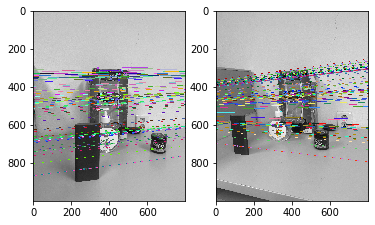

In [8]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [ ]:
cv2.imshow('left image', img5)
cv2.imshow('right image', img3)
cv2.waitKey(0)
cv2.destoryAllwindow()